In [18]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from OA_utils.data_utils import *

In [19]:
data_dir = "C:\\Users\\bakel\\Desktop\\GRFMuscleModel\\Old_Young_Walking_Data\\"
# load the data
train_data = np.load(data_dir + 'mixed_train_data.npz')
val_data = np.load(data_dir + 'mixed_val_data.npz')
test_data = np.load(data_dir + 'mixed_test_data.npz')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [20]:
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1054, 100, 3)
y_train shape: (1054, 100, 9)
X_val shape: (152, 100, 3)
y_val shape: (152, 100, 9)
X_test shape: (116, 100, 3)
y_test shape: (116, 100, 9)


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 [Text(0, -500.0, '−500'),
  Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000'),
  Text(0, 4500.0, '4500')])

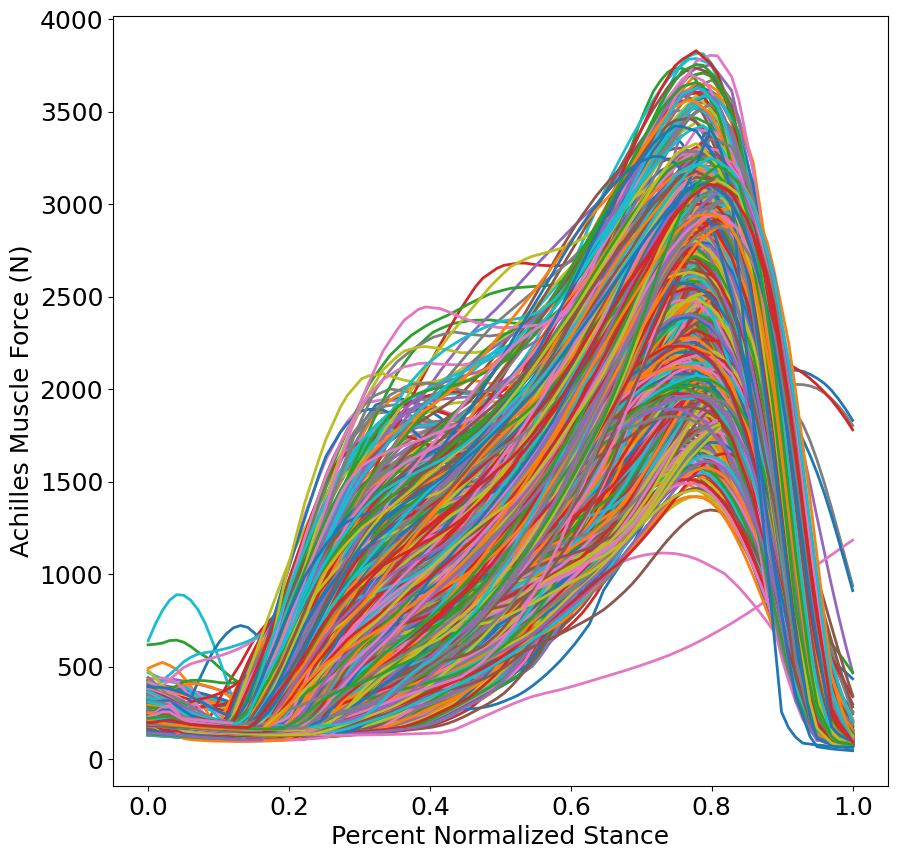

In [21]:
figure = plt.figure(figsize=(10, 10))

num_achilles_segments = len(y_train[:, :, 8])
perc_stance = np.linspace(0, 1, 100)

for i in range(num_achilles_segments):
    plt.plot(perc_stance, y_train[i, :, 8], linewidth=2)

plt.ylabel("Achilles Muscle Force (N)", fontsize=18)
plt.xlabel("Percent Normalized Stance", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        # call the parent class constructor
        super(LSTMModel, self).__init__()
        
        # define the LSTM layer
        # nn.LSTM(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # fully connected layer to map from hidden state to output features
        # nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # pass through LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch, seq_length, hidden_size)
        
        # pass through fully connected layer to get the output
        output = self.fc(lstm_out)  # output shape: (batch, seq_length, output_size)
        
        return output

In [23]:
from itertools import product

# define hyperparameters
hidden_sizes = [32, 64, 128]
num_layers = [2, 3]
dropout_rates = [0.0, 0.25, 0.5]
learing_rates = [1e-4, 5e-4, 1e-3]
batch_sizes = [32, 64]
regularization = [1e-5, 1e-4, 1e-3]

param_grid = list(product(hidden_sizes, num_layers, dropout_rates, learing_rates, batch_sizes, regularization))
print(f"Number of hyperparameter combinations: {len(param_grid)}")
# print(param_grid)

Number of hyperparameter combinations: 324


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")# define device (GPU if available)


Device: cuda


In [25]:
from torch.utils.data import TensorDataset, DataLoader

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# # create dataloaders from datasets
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
def train_eval(train_dataset, val_dataset, hidden_size, num_layers, dropout_rate, 
               learning_rate, batch_size, regularization, num_epochs=50):
    # # unpack the hyperparameters
    # hidden_size, num_layers, dropout_rate, learning_rate, batch_size, regularization = params
    # print('------------------------------------------------------------')
    # print(f"hidden_size={hidden_size}, num_layers={num_layers}, dropout_rate={dropout_rate}")
    # print(f"learning_rate={learning_rate}, batch_size={batch_size}, regularization={regularization}")
    # print('------------------------------------------------------------')
    
    # prepare DataLoader with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # initialize the model
    model = LSTMModel(input_size=3, hidden_size=hidden_size, num_layers=num_layers, output_size=9, dropout=dropout_rate)
    
    # move the model to the device
    model.to(device)    
    
    # initialize the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
    
    # early stopping setup
    patience = 10
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # training loop
    for epoch in range(num_epochs):
        # set the model to train mode
        model.train()
        
        # initialize training loss
        train_loss = 0.0

        # iterate over the training data
        for X_batch, y_batch in train_loader:
            # zero the gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(X_batch)
            
            # calculate the loss
            loss = criterion(outputs, y_batch)
            
            # backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # update training loss
            train_loss += loss.item() * X_batch.size(0)
        
        # average training loss over all samples
        train_loss /= len(train_loader.dataset)
        
        # validation step
        # set the model to evaluation mode
        model.eval()
        
        # initialize validation loss
        val_loss = 0.0
        
        # turn off gradients for validation
        with torch.no_grad():
            # iterate over the validation data
            for X_batch, y_batch in val_loader:
                # forward pass
                outputs = model(X_batch)
                
                # calculate the loss
                loss = criterion(outputs, y_batch)
                
                # update validation loss
                val_loss += loss.item() * X_batch.size(0)

        # average validation loss over all samples
        val_loss /= len(val_loader.dataset)
        
        # # print progress
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # early stopping check
        if val_loss < best_val_loss:
            # save best validation loss
            best_val_loss = val_loss
            
            # reset epochs without improvement
            epochs_without_improvement = 0
            
            # save the best model
            # torch.save(model.state_dict(), 'best_model.pth')
            best_model_state_dict = model.state_dict()
        else:
            # increment epochs without improvement
            epochs_without_improvement += 1

        # break if patience limit is reached
        if epochs_without_improvement >= patience:
            break

    # load the best model's state for this set of hyperparameters
    # model.load_state_dict(torch.load('best_model.pth'))
    model.load_state_dict(best_model_state_dict)
    
    # return the best validation loss
    return best_val_loss, model

In [27]:
import optuna

def objective(trial):
    # Sample hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 3, step=1)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, log=False)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    regularization = trial.suggest_float('regularization', 1e-5, 1e-2, log=True)

    # Train and evaluate with these hyperparameters
    val_loss, _ = train_eval(train_dataset, val_dataset, hidden_size, num_layers, dropout_rate, 
                             learning_rate, batch_size, regularization, num_epochs=200)
    
    # Return the validation loss (minimize this value)
    return val_loss

In [30]:
# Define the study
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Start the optimization
study.optimize(objective, n_trials=100)  # Run 100 trials

[I 2025-11-21 14:28:53,304] A new study created in memory with name: no-name-e3c7ca59-8e07-4970-9ace-1e2fa241e1de
[I 2025-11-21 14:28:58,492] Trial 0 finished with value: 241322.59210526315 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.36163003033610147, 'learning_rate': 0.00010282421980344253, 'batch_size': 128, 'regularization': 4.357487315085071e-05}. Best is trial 0 with value: 241322.59210526315.
[I 2025-11-21 14:29:02,225] Trial 1 finished with value: 226706.40953947368 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.06950242761406294, 'learning_rate': 0.0012505906510626396, 'batch_size': 128, 'regularization': 0.002625447524842803}. Best is trial 1 with value: 226706.40953947368.
[I 2025-11-21 14:29:05,962] Trial 2 finished with value: 210559.15789473685 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.06417448924528707, 'learning_rate': 0.002295024352573483, 'batch_size': 128, 'regularization': 0.00395898603

In [31]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.014234910574233733, 'learning_rate': 0.008653462675410168, 'batch_size': 32, 'regularization': 0.00022015343234916854}


In [32]:
# Train the final model with the best hyperparameters
final_val_loss, best_model = train_eval(train_dataset, val_dataset,
                                        hidden_size=best_params['hidden_size'],
                                        num_layers=best_params['num_layers'],
                                        dropout_rate=best_params['dropout_rate'],
                                        learning_rate=best_params['learning_rate'],
                                        batch_size=best_params['batch_size'],
                                        regularization=best_params['regularization'],
                                        num_epochs=1000)

In [33]:
torch.save(best_model.state_dict(), '..\models\Mixed_lstm.pth')

In [34]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set model to evaluation mode
best_model.eval()

# initialize test loss
test_loss = 0

criterion = nn.MSELoss()

# no need to calculate gradients during testing
with torch.no_grad():
    # forward pass
    test_outputs = best_model(X_test_tensor)
    
    # calculate loss
    test_loss = criterion(test_outputs, y_test_tensor).item()

# print test loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 8802.3223


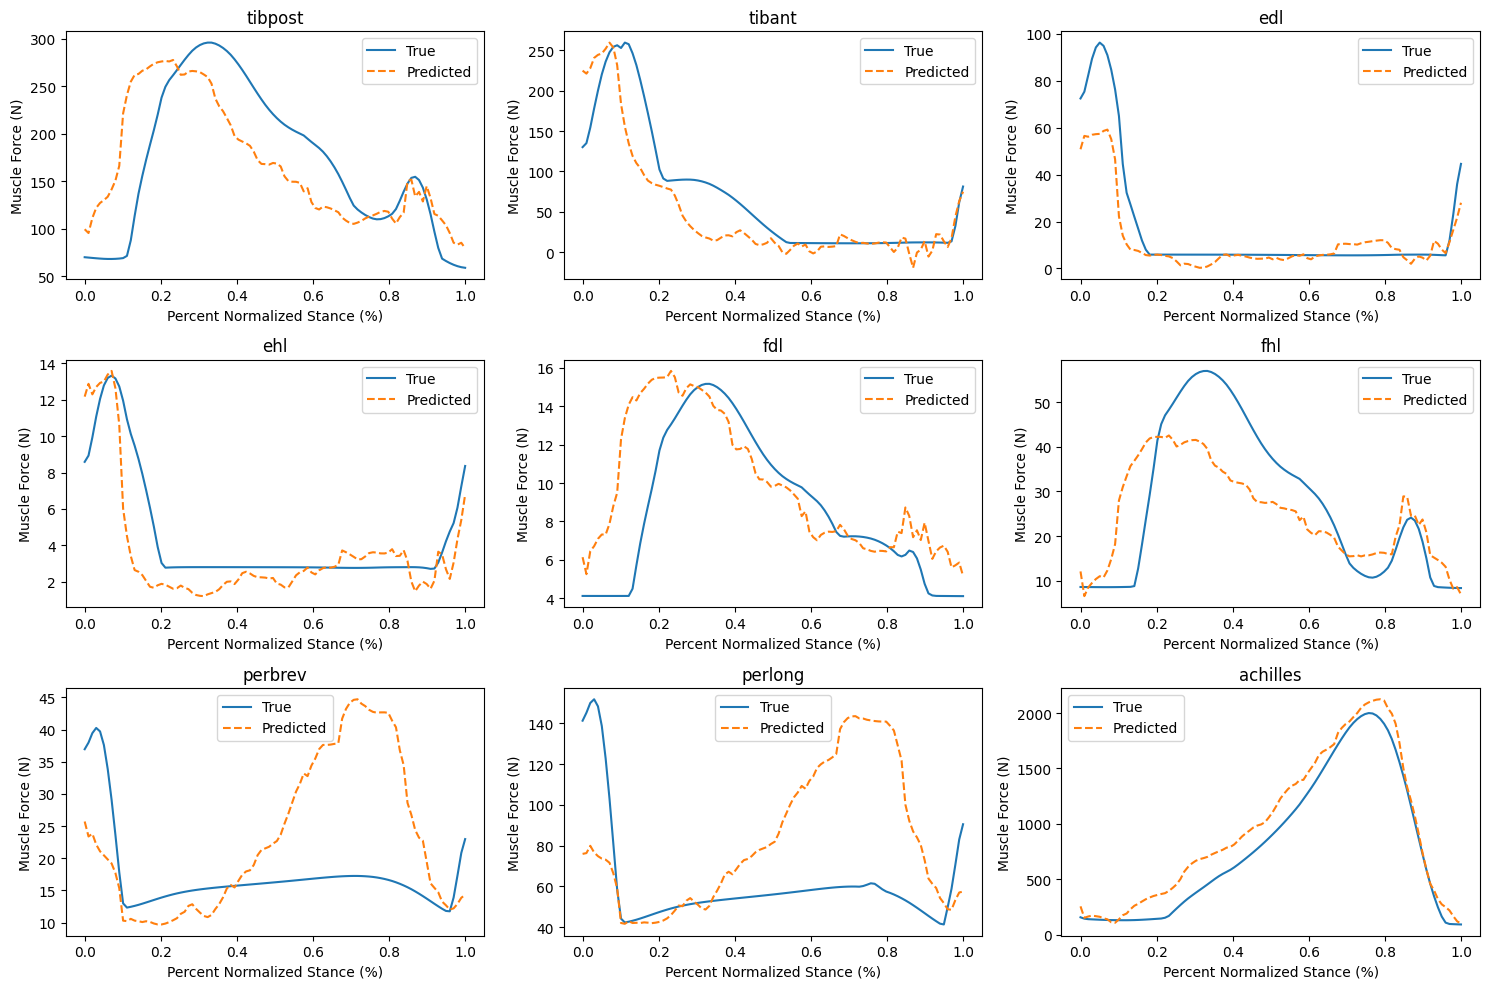

In [35]:
# Move predictions and ground truth to CPU for visualization
pred = test_outputs[0].cpu().numpy()  # Shape: (seq_length, 9)
true = y_test_tensor[0].cpu().numpy()      # Shape: (seq_length, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i in range(9):
    axes[i].plot(perc_stance, true[:, i], label="True")
    axes[i].plot(perc_stance, pred[:, i], label="Predicted", linestyle='dashed')
    axes[i].set_title(muscle_dict[i])
    axes[i].set_xlabel("Percent Normalized Stance (%)")
    axes[i].set_ylabel("Muscle Force (N)")
    axes[i].legend()

plt.tight_layout()
plt.show()